# Импорты

In [1]:
!pip install numpy==1.26.0
!pip install pandas
!pip install catboost -q
!pip install ipynbname -q
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [29]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.utils.class_weight import compute_class_weight

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from google.colab import drive
import ipynbname
import shutil

import datetime
import pytz

import os

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Константы

In [3]:
SEED = 42
MODE = 'validation'

# paths
DRIVE_PATH = './gdrive/MyDrive/ml_hits_1_module'
TRAIN_FILE_NAME = 'train.csv'
TEST_FILE_NAME = 'test.csv'
SUBMISSION_FILE_NAME = 'sample_submission.csv'
DATA_PATH = DRIVE_PATH + '/data'
SUBS_PATH = DRIVE_PATH + '/submits'
NOTEBOOKS_PATH = DRIVE_PATH + '/notebooks'

# Вспомогательные функции

In [4]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_all_seeds(SEED)

# Загрузка данных

In [5]:
path = os.path.join(DATA_PATH, TRAIN_FILE_NAME)
train = pd.read_csv(path)
print(train.shape)
train.sample(5)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
304,0337_02,Mars,False,F/63/S,TRAPPIST-1e,19.0,False,417.0,349.0,634.0,3.0,1057.0,Weros Perle,True
2697,2891_01,Earth,False,G/460/S,TRAPPIST-1e,18.0,False,4.0,904.0,0.0,0.0,1.0,Gleney Ortinericey,False
8424,8998_01,Earth,True,G/1449/S,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,Gerry Englence,False
1672,1771_01,Earth,False,G/291/P,TRAPPIST-1e,35.0,False,0.0,338.0,436.0,NaN,0.0,Antone Cardner,True
8458,9034_02,Europa,True,D/288/P,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Errairk Crakete,True


In [6]:
path = os.path.join(DATA_PATH, TEST_FILE_NAME)
test = pd.read_csv(path)
print(test.shape)
test.sample(5)

(4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
2824,6244_01,Europa,False,A/61/P,TRAPPIST-1e,37.0,False,213.0,5.0,0.0,439.0,1190.0,Atino Spopting
2117,4583_03,Mars,False,D/146/S,TRAPPIST-1e,50.0,False,953.0,1628.0,1184.0,0.0,1.0,Per Parte
1332,2850_03,Mars,False,E/192/S,TRAPPIST-1e,26.0,False,1208.0,90.0,1.0,0.0,0.0,Shog Nuthe
3749,8183_01,Earth,False,E/526/P,TRAPPIST-1e,51.0,False,0.0,0.0,7.0,365.0,625.0,Jayne Hayder
2827,6255_01,Europa,True,B/212/P,TRAPPIST-1e,42.0,False,0.0,0.0,0.0,0.0,0.0,Schird Siccertful


# Обработка данных

In [7]:
train.head(50)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


# EDA

## Преобразование фичей

In [8]:
!pip install gender-guesser
import gender_guesser.detector as gender # Предсказание пола

gender_detector = gender.Detector()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 5.1 MB/s eta 0:00:00


In [9]:
def predict_gender(name):
    # Получаем первую часть имени (на случай, если имя состоит из нескольких слов)
    first_name = name
    # Определяем пол
    gender_pred = gender_detector.get_gender(first_name)
    # Упрощаем результат: 'male' или 'female', остальное считаем 'unknown'
    if gender_pred in ['male', 'mostly_male']:
        return 'male'
    elif gender_pred in ['female', 'mostly_female']:
        return 'female'
    else:
        return 'unknown'

In [10]:
def process_features(df):
    # Разбиваем на PassengerId на PassengerGroup и PassengerNumberInGroup
    df['PassengerGroup'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['PassengerNumberInGroup'] = df['PassengerId'].apply(lambda x: int(x.split('_')[1]))

    # Разбиваем Cabin на Deck, Num, Side
    df['Cabin'] = df['Cabin'].astype(str)
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if x != 'nan' else np.nan)
    df['Num'] = df['Cabin'].apply(lambda x: int(x.split('/')[1]) if x != 'nan' else np.nan)
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if x != 'nan' else np.nan)

    # Разбиваем Name на Surname и Name
    df['Name'] = df['Name'].fillna('Unknown Unknown') # Если имя неизвестно
    df['Surname'] = df['Name'].apply(lambda x: x.split()[1])
    df['Name'] = df['Name'].apply(lambda x: x.split()[0])

    # Придумываем новые фичи

    # Сколько всего заплатил пассажир
    df['PaidSum'] = (df['RoomService'] + df['FoodCourt'] +
                     df['ShoppingMall'] + df['Spa'] +
                     df['VRDeck'])
    # Платил ли пассажир за доп услуги
    df['PaidExtra'] = (df['RoomService'] + df['FoodCourt'] +
                       df['ShoppingMall'] + df['Spa'] +
                       df['VRDeck'] != 0.0)
    # Сколько человек в группе пассажира
    df['PassengersCountInGroup'] = df.groupby('PassengerGroup')['PassengerNumberInGroup'].transform('max')
    # В одиночку ли путешествует
    df['IsAlone'] = (df['PassengersCountInGroup'] == 1) & (df['PassengerNumberInGroup'] == 1)
    # Путешествует ли с родственниками
    df['IsTravelWithFamily'] = df.groupby('PassengerGroup')['Surname'].transform(lambda x: (x == x.iloc[0]).sum() > 1)
    # Пытаемся понять пол по имени
    df['Gender'] = df['Name'].apply(predict_gender)

    # Удаляем лишнее
    cols2drop = ['PassengerId', 'Cabin', 'Name', 'Surname']
    df = df.drop(cols2drop, axis=1, errors='ignore')

    return df

In [11]:
train = process_features(train)

### Применение изменений

In [12]:
target = ['Transported']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination',
                'VIP', 'Deck', 'Side', 'PaidExtra', 'IsAlone',
                'IsTravelWithFamily', 'Gender']

filtered_features = [i for i in train.columns if (i not in target)]
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', target)

cat_features : 10 ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'PaidExtra', 'IsAlone', 'IsTravelWithFamily', 'Gender']
num_features : 11 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerGroup', 'PassengerNumberInGroup', 'Num', 'PaidSum', 'PassengersCountInGroup']
targets ['Transported']


In [13]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PassengerNumberInGroup,Deck,Num,Side,PaidSum,PaidExtra,PassengersCountInGroup,IsAlone,IsTravelWithFamily,Gender
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,1,B,0.0,P,0.0,False,1,True,False,unknown
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,1,F,0.0,S,736.0,True,1,True,False,unknown
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,1,A,0.0,S,10383.0,True,2,False,True,unknown
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,2,A,0.0,S,5176.0,True,2,False,True,unknown
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,1,F,1.0,S,1091.0,True,1,True,False,male


## Пропуски

In [14]:
train.isna().sum().sort_values(ascending=False)

,0
PaidSum,908
CryoSleep,217
ShoppingMall,208
VIP,203
HomePlanet,201
Deck,199
Num,199
Side,199
VRDeck,188
FoodCourt,183


In [15]:
train.shape

(8693, 22)

Пробуем заменить

In [16]:
def replace_nans(df):
  # Численные фичи заполняем медианами
  for feature in num_features:
      train[feature] = train[feature].astype(float)

  median_values = train[num_features].median()
  df[num_features] = df[num_features].fillna(median_values)

  # Несбалансированные категориальные фичи заполняем самым популярным классом
  disbalanced_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Gender']

  for feature in disbalanced_features:
      df[feature] = df[feature].fillna(train[feature].mode()[0])

  # Остальные категориальные фичи заполняем рандомным классом
  balanced_features = [i for i in cat_features if i not in disbalanced_features]

  for feature in balanced_features:
      non_nan_values = df[feature].dropna().unique()

      # Заменяем NaN на случайное значение из non_nan_values
      df[feature] = df[feature].apply(lambda x: np.random.choice(non_nan_values) if pd.isna(x) else x)

  return df

In [17]:
train = replace_nans(train)

<ipython-input-16-e085b354fe4b>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = df[feature].fillna(train[feature].mode()[0])


## Графики

### Выбросы

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>],
       [<Axes: title={'center': 'ShoppingMall'}>,
        <Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>],
       [<Axes: title={'center': 'PassengerGroup'}>,
        <Axes: title={'center': 'PassengerNumberInGroup'}>,
        <Axes: title={'center': 'Num'}>],
       [<Axes: title={'center': 'PaidSum'}>,
        <Axes: title={'center': 'PassengersCountInGroup'}>, <Axes: >]],
      dtype=object)

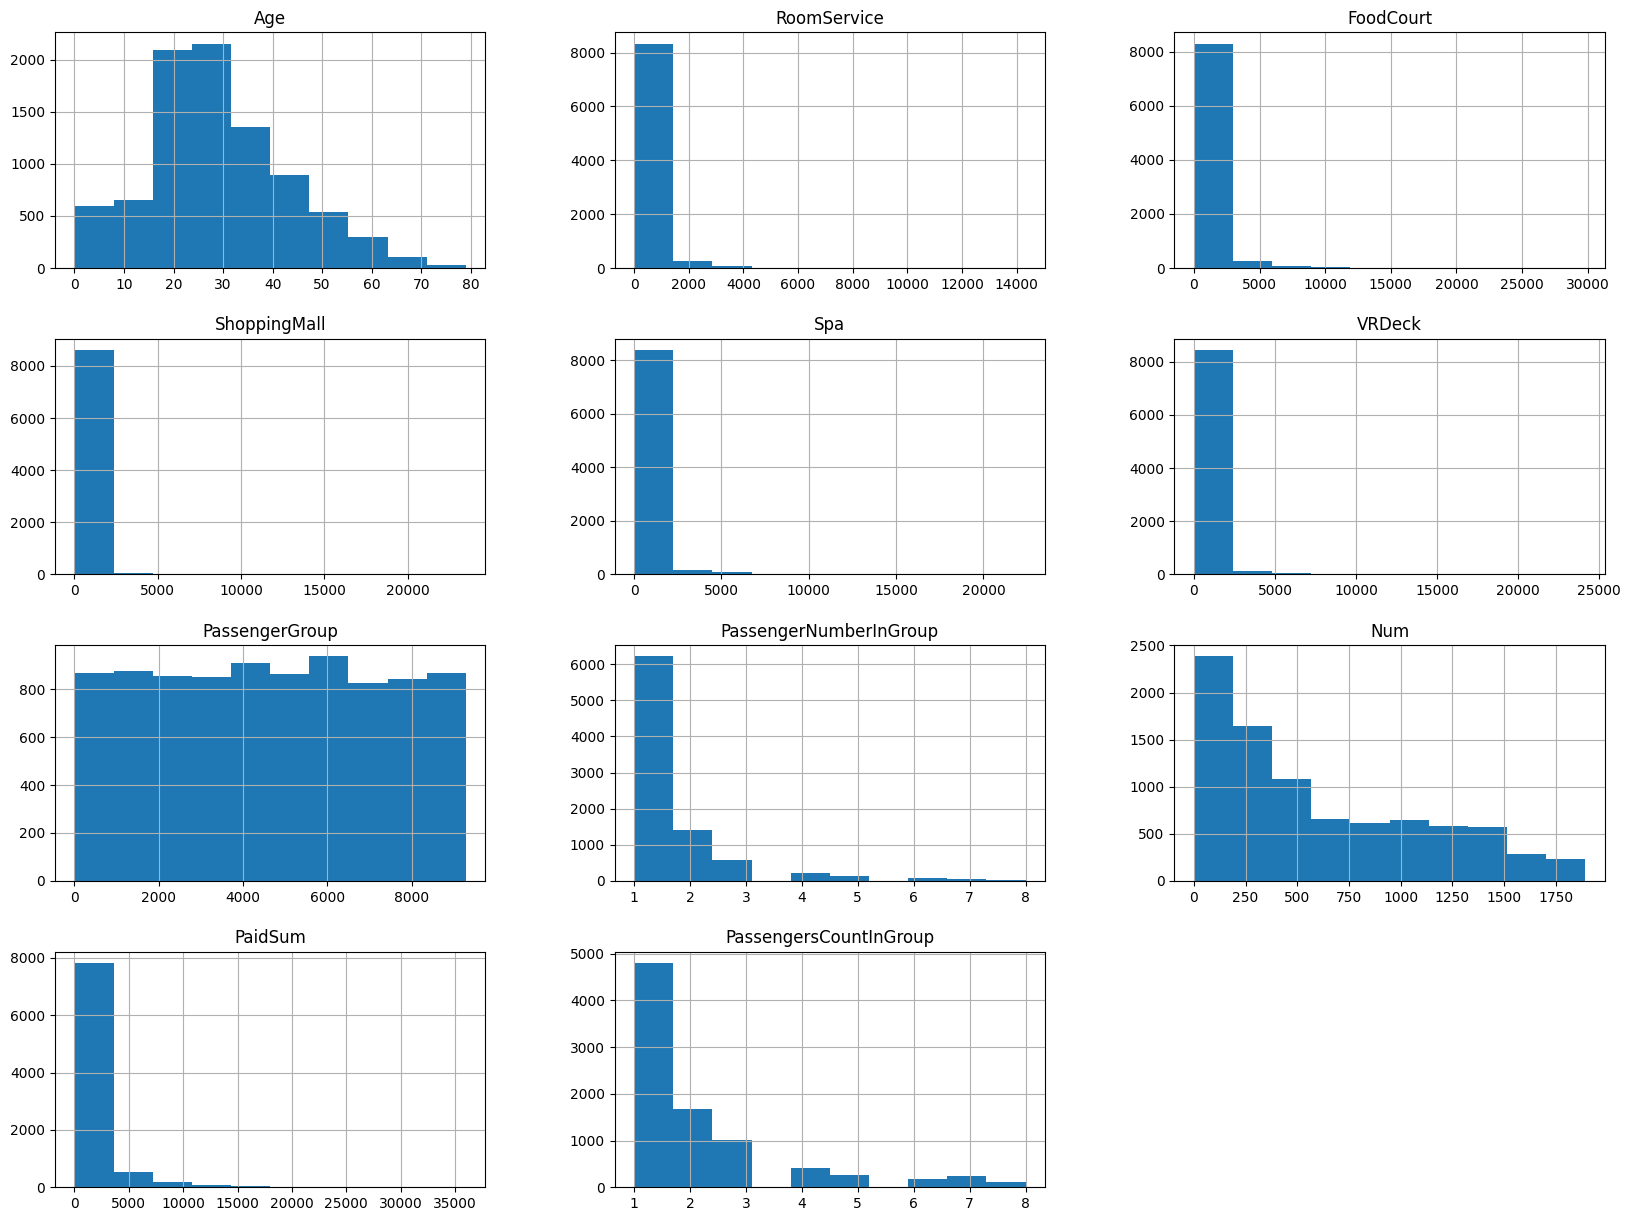

In [18]:
train.hist(figsize=(20,15))

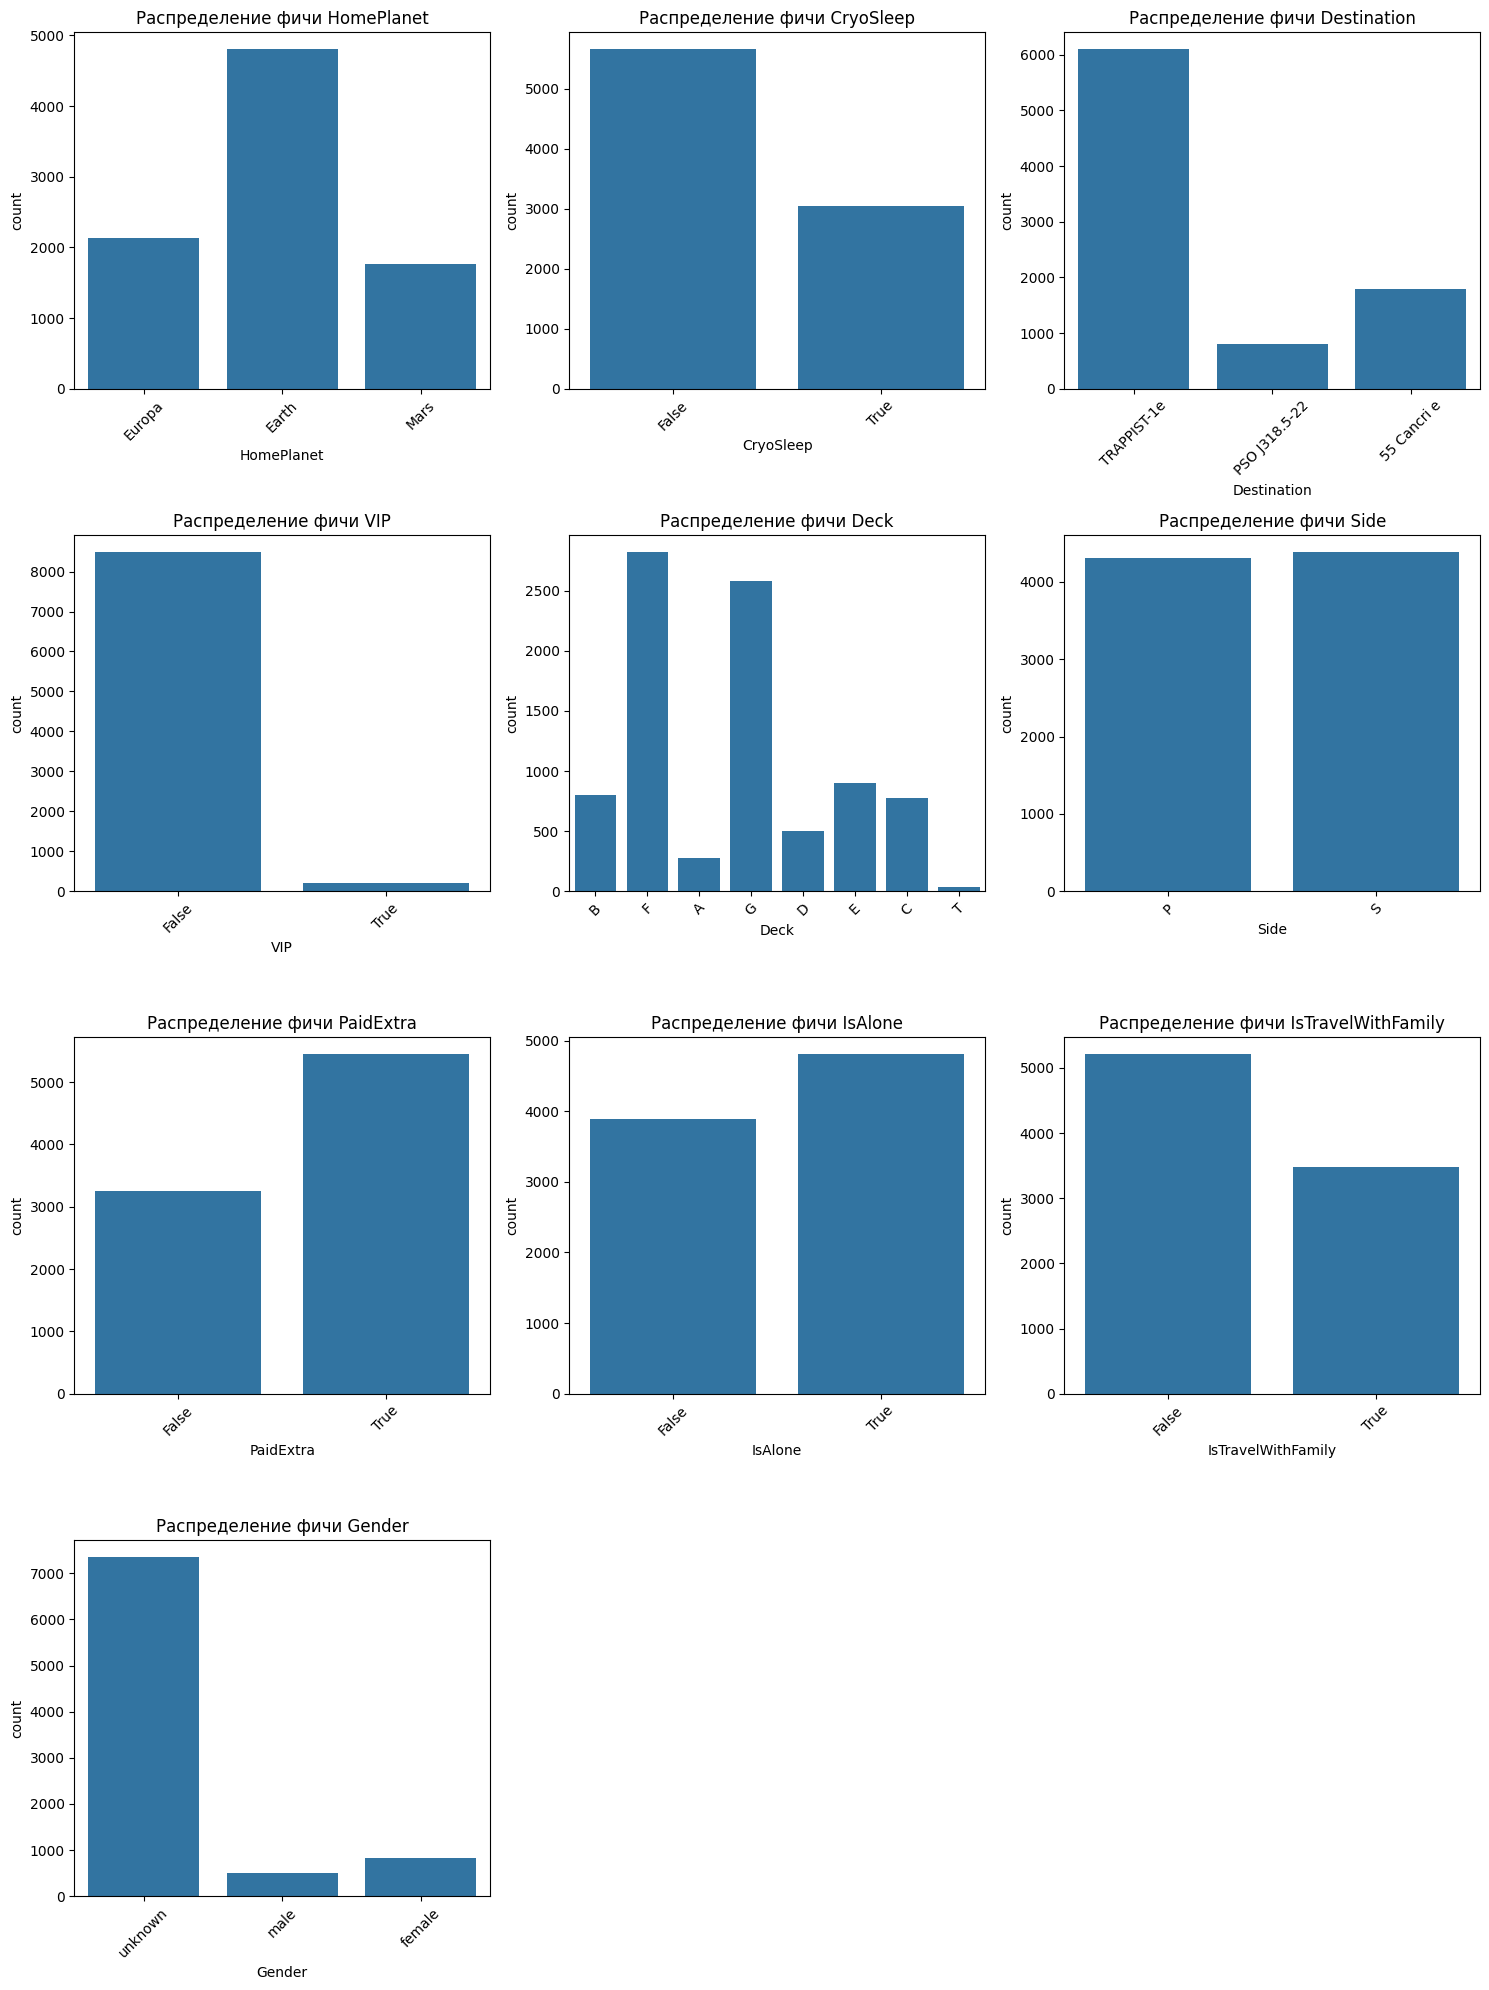

In [19]:
n_cols = 3
n_rows = (len(cat_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, data=train, ax=axes[i])
    axes[i].set_title(f'Распределение фичи {feature}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Смотрим таргет

In [20]:
train['Transported'].value_counts()

,count
Transported,
True,4378
False,4315


Таргет сбалансирован

In [21]:
from sklearn.preprocessing import LabelEncoder
def show_corr_matrix(data):
    data_new = data.copy()
    for col in cat_features:
        data_new[col] = LabelEncoder().fit_transform(data[col])

    sns.heatmap(data_new.corr())

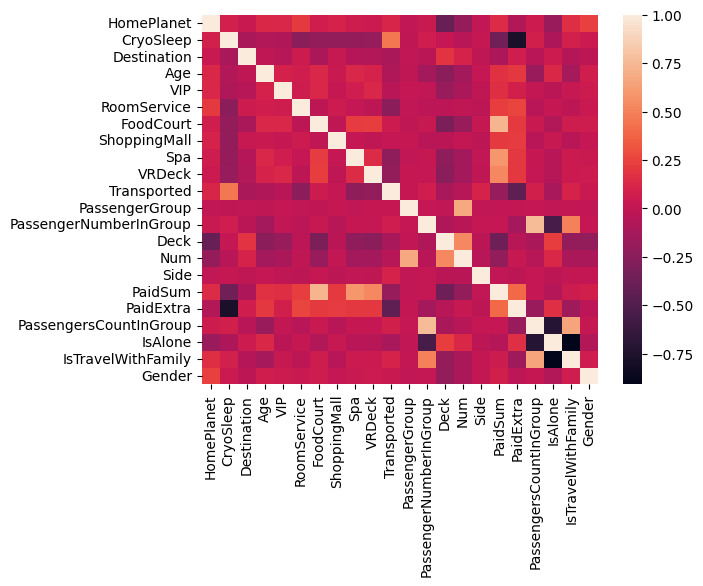

In [22]:
show_corr_matrix(train)

In [23]:
pd.crosstab(
    train['CryoSleep'],
    train['Transported']
).style.background_gradient('RdYlGn')

Transported,False,True
CryoSleep,,
False,3761,1895
True,554,2483


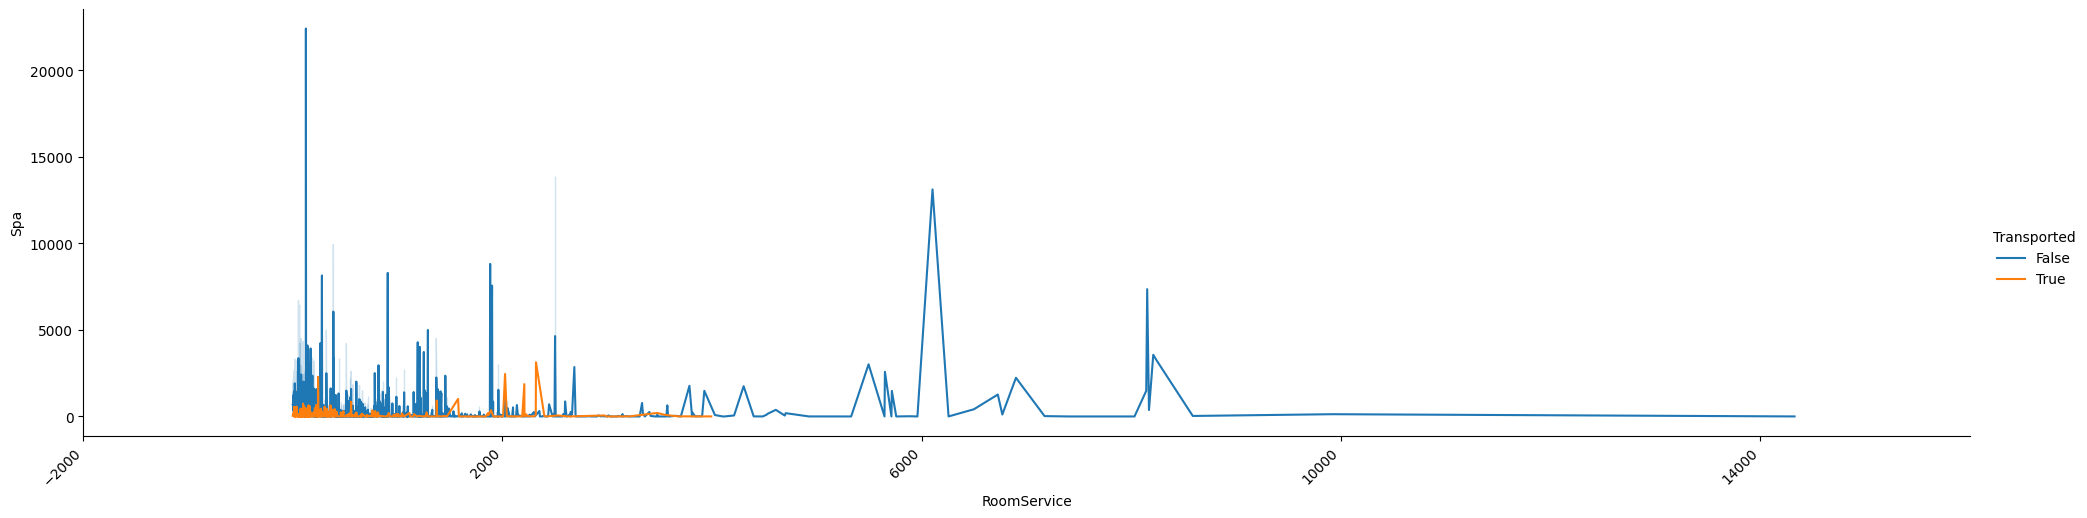

In [24]:
sns.relplot(
    data=train,
    kind='line',
    x='RoomService',
    y='Spa',
    hue='Transported',
    aspect=4
).set_xticklabels(rotation=45, horizontalalignment='right', step=2)

# Обучение

In [25]:
X = train.drop(target, axis=1, errors='ignore')
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=SEED)

In [30]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

## Logistic regression

In [32]:
clf = LogisticRegression(random_state=SEED, max_iter=1000)
clf.fit(X_train_encoded, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, random_state=42)

In [33]:
y_pred = clf.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7471


## CatBoost + Optuna

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False,
        'cat_features': cat_features,
        'random_state': SEED
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=150,
        plot=False
    )

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-03-06 21:12:33,954] A new study created in memory with name: no-name-5842ea0d-7d6f-4891-9955-06702e2188a2


0:	learn: 0.6857008	test: 0.6866738	best: 0.6866738 (0)	total: 145ms	remaining: 1m 56s
150:	learn: 0.3886267	test: 0.4294319	best: 0.4294319 (150)	total: 10.2s	remaining: 44.2s
300:	learn: 0.3326350	test: 0.3906823	best: 0.3906739 (298)	total: 19.9s	remaining: 33.3s
450:	learn: 0.2988381	test: 0.3737993	best: 0.3730106 (433)	total: 28.3s	remaining: 22.2s
600:	learn: 0.2740109	test: 0.3676625	best: 0.3671386 (569)	total: 31.9s	remaining: 10.8s
750:	learn: 0.2526570	test: 0.3670927	best: 0.3641965 (691)	total: 37.5s	remaining: 2.69s


[I 2025-03-06 21:13:13,342] Trial 0 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 805, 'learning_rate': 0.011351308425298882, 'depth': 8, 'l2_leaf_reg': 0.004760812477255313, 'random_strength': 0.035521031002808304, 'bagging_temperature': 0.6652113459798238, 'border_count': 147}. Best is trial 0 with value: 0.8160919540229885.


804:	learn: 0.2459414	test: 0.3685289	best: 0.3641965 (691)	total: 38.7s	remaining: 0us

bestTest = 0.3641964577
bestIteration = 691

Shrink model to first 692 iterations.
0:	learn: 0.6827088	test: 0.6846539	best: 0.6846539 (0)	total: 14.1ms	remaining: 10.1s
150:	learn: 0.4006123	test: 0.4254207	best: 0.4254207 (150)	total: 1.85s	remaining: 6.91s
300:	learn: 0.3640538	test: 0.3938601	best: 0.3938601 (300)	total: 3.62s	remaining: 4.97s
450:	learn: 0.3449546	test: 0.3823755	best: 0.3823524 (449)	total: 5.4s	remaining: 3.15s
600:	learn: 0.3285484	test: 0.3786046	best: 0.3786046 (600)	total: 7.15s	remaining: 1.34s


[I 2025-03-06 21:13:23,160] Trial 1 finished with value: 0.8275862068965517 and parameters: {'n_estimators': 714, 'learning_rate': 0.02411184060751367, 'depth': 5, 'l2_leaf_reg': 0.002656300020029928, 'random_strength': 0.004568952284776636, 'bagging_temperature': 0.27283651937346454, 'border_count': 41}. Best is trial 1 with value: 0.8275862068965517.


713:	learn: 0.3191184	test: 0.3739814	best: 0.3739216 (710)	total: 9.52s	remaining: 0us

bestTest = 0.3739215544
bestIteration = 710

Shrink model to first 711 iterations.
0:	learn: 0.6510974	test: 0.6564836	best: 0.6564836 (0)	total: 49ms	remaining: 33.6s
150:	learn: 0.2828828	test: 0.3753486	best: 0.3753486 (150)	total: 3.89s	remaining: 13.8s
300:	learn: 0.2157601	test: 0.3656928	best: 0.3616800 (223)	total: 6.95s	remaining: 8.89s
450:	learn: 0.1687889	test: 0.3656228	best: 0.3610056 (414)	total: 10.1s	remaining: 5.26s
600:	learn: 0.1354623	test: 0.3930103	best: 0.3610056 (414)	total: 14.9s	remaining: 2.1s


[I 2025-03-06 21:13:40,575] Trial 2 finished with value: 0.8275862068965517 and parameters: {'n_estimators': 686, 'learning_rate': 0.07289989776390352, 'depth': 8, 'l2_leaf_reg': 0.9041746850585151, 'random_strength': 0.20755080987601227, 'bagging_temperature': 0.03733435589181988, 'border_count': 50}. Best is trial 1 with value: 0.8275862068965517.


685:	learn: 0.1188933	test: 0.4074741	best: 0.3610056 (414)	total: 17s	remaining: 0us

bestTest = 0.3610056421
bestIteration = 414

Shrink model to first 415 iterations.
0:	learn: 0.5950298	test: 0.6064955	best: 0.6064955 (0)	total: 22.2ms	remaining: 11.1s
150:	learn: 0.1439083	test: 0.4772215	best: 0.3966577 (33)	total: 3.05s	remaining: 7.06s
300:	learn: 0.0603344	test: 0.5495503	best: 0.3966577 (33)	total: 6.15s	remaining: 4.09s
450:	learn: 0.0303991	test: 0.5861048	best: 0.3966577 (33)	total: 10.3s	remaining: 1.14s


[I 2025-03-06 21:13:53,076] Trial 3 finished with value: 0.7816091954022989 and parameters: {'n_estimators': 501, 'learning_rate': 0.17809430653859507, 'depth': 8, 'l2_leaf_reg': 0.025592813511002597, 'random_strength': 0.0037010229391279633, 'bagging_temperature': 0.7014727108695877, 'border_count': 35}. Best is trial 1 with value: 0.8275862068965517.


500:	learn: 0.0235598	test: 0.6255908	best: 0.3966577 (33)	total: 12.2s	remaining: 0us

bestTest = 0.3966577428
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 0.6850613	test: 0.6859374	best: 0.6859374 (0)	total: 25.4ms	remaining: 22.4s
150:	learn: 0.3840846	test: 0.4277049	best: 0.4277049 (150)	total: 3.07s	remaining: 14.9s
300:	learn: 0.3301813	test: 0.3951976	best: 0.3948879 (299)	total: 6s	remaining: 11.6s
450:	learn: 0.2983847	test: 0.3855062	best: 0.3853569 (360)	total: 8.96s	remaining: 8.6s
600:	learn: 0.2726281	test: 0.3794719	best: 0.3792705 (597)	total: 14.3s	remaining: 6.74s
750:	learn: 0.2514799	test: 0.3766591	best: 0.3764218 (748)	total: 19.1s	remaining: 3.38s


[I 2025-03-06 21:14:15,236] Trial 4 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 884, 'learning_rate': 0.0124181504073857, 'depth': 8, 'l2_leaf_reg': 0.019597278751401735, 'random_strength': 0.010328062388755728, 'bagging_temperature': 0.5117934560449149, 'border_count': 45}. Best is trial 1 with value: 0.8275862068965517.


883:	learn: 0.2343974	test: 0.3771925	best: 0.3763866 (846)	total: 21.8s	remaining: 0us

bestTest = 0.376386605
bestIteration = 846

Shrink model to first 847 iterations.
0:	learn: 0.6855246	test: 0.6862954	best: 0.6862954 (0)	total: 17.6ms	remaining: 10.3s
150:	learn: 0.4205981	test: 0.4491908	best: 0.4491908 (150)	total: 3.17s	remaining: 9.18s
300:	learn: 0.3764629	test: 0.4082207	best: 0.4082207 (300)	total: 6.62s	remaining: 6.31s
450:	learn: 0.3564555	test: 0.3922970	best: 0.3922970 (450)	total: 9.36s	remaining: 2.84s


[I 2025-03-06 21:14:26,989] Trial 5 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 588, 'learning_rate': 0.01362161978538059, 'depth': 6, 'l2_leaf_reg': 0.23143122768445007, 'random_strength': 0.00298956417450948, 'bagging_temperature': 0.599873335088271, 'border_count': 197}. Best is trial 1 with value: 0.8275862068965517.


587:	learn: 0.3433134	test: 0.3827677	best: 0.3827677 (587)	total: 11.5s	remaining: 0us

bestTest = 0.382767694
bestIteration = 587

0:	learn: 0.6568029	test: 0.6644330	best: 0.6644330 (0)	total: 26.7ms	remaining: 4.97s
150:	learn: 0.1799239	test: 0.4382821	best: 0.3940579 (100)	total: 3.53s	remaining: 843ms


[I 2025-03-06 21:14:32,241] Trial 6 finished with value: 0.8275862068965517 and parameters: {'n_estimators': 187, 'learning_rate': 0.06088083604496427, 'depth': 9, 'l2_leaf_reg': 0.0027292833723341838, 'random_strength': 0.014965061034373206, 'bagging_temperature': 0.34478925477085653, 'border_count': 158}. Best is trial 1 with value: 0.8275862068965517.


186:	learn: 0.1525215	test: 0.4331502	best: 0.3940579 (100)	total: 5.03s	remaining: 0us

bestTest = 0.3940578881
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.6867166	test: 0.6875891	best: 0.6875891 (0)	total: 94.9ms	remaining: 1m 14s
150:	learn: 0.4324286	test: 0.4595327	best: 0.4595327 (150)	total: 3.75s	remaining: 15.8s
300:	learn: 0.3861469	test: 0.4155135	best: 0.4154524 (297)	total: 6.07s	remaining: 9.82s
450:	learn: 0.3638737	test: 0.3979502	best: 0.3977588 (449)	total: 8.37s	remaining: 6.25s
600:	learn: 0.3499243	test: 0.3877425	best: 0.3877425 (600)	total: 10.6s	remaining: 3.31s
750:	learn: 0.3367214	test: 0.3816999	best: 0.3816999 (750)	total: 14.1s	remaining: 695ms


[I 2025-03-06 21:14:48,601] Trial 7 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 788, 'learning_rate': 0.011459509798460414, 'depth': 6, 'l2_leaf_reg': 0.04693175601688789, 'random_strength': 0.19126297187838542, 'bagging_temperature': 0.658705942209425, 'border_count': 225}. Best is trial 1 with value: 0.8275862068965517.


787:	learn: 0.3337867	test: 0.3803085	best: 0.3795081 (778)	total: 15.3s	remaining: 0us

bestTest = 0.3795081158
bestIteration = 778

Shrink model to first 779 iterations.
0:	learn: 0.6851583	test: 0.6868524	best: 0.6868524 (0)	total: 16.6ms	remaining: 11.6s
150:	learn: 0.4349592	test: 0.4595424	best: 0.4595424 (150)	total: 1.88s	remaining: 6.88s
300:	learn: 0.3985355	test: 0.4330305	best: 0.4330305 (300)	total: 3.75s	remaining: 5.02s
450:	learn: 0.3541701	test: 0.4007060	best: 0.4007060 (450)	total: 5.85s	remaining: 3.28s
600:	learn: 0.3299242	test: 0.3957606	best: 0.3948764 (592)	total: 8s	remaining: 1.37s


[I 2025-03-06 21:14:58,459] Trial 8 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 704, 'learning_rate': 0.03419616205710028, 'depth': 6, 'l2_leaf_reg': 3.060442346937493, 'random_strength': 5.227436985035652, 'bagging_temperature': 0.1274359025503129, 'border_count': 55}. Best is trial 1 with value: 0.8275862068965517.


703:	learn: 0.3172072	test: 0.3940674	best: 0.3934859 (671)	total: 9.45s	remaining: 0us

bestTest = 0.3934859373
bestIteration = 671

Shrink model to first 672 iterations.
0:	learn: 0.6595511	test: 0.6606907	best: 0.6606907 (0)	total: 21.8ms	remaining: 12.1s
150:	learn: 0.2988798	test: 0.3649250	best: 0.3646029 (149)	total: 4.61s	remaining: 12.3s
300:	learn: 0.2293974	test: 0.3430211	best: 0.3430211 (300)	total: 7.26s	remaining: 6.13s
450:	learn: 0.1875804	test: 0.3510881	best: 0.3411095 (367)	total: 9.95s	remaining: 2.29s


[I 2025-03-06 21:15:10,529] Trial 9 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 555, 'learning_rate': 0.061625727231321974, 'depth': 7, 'l2_leaf_reg': 0.008024972373583211, 'random_strength': 0.27190251272234556, 'bagging_temperature': 0.036209436524314076, 'border_count': 96}. Best is trial 1 with value: 0.8275862068965517.


554:	learn: 0.1625893	test: 0.3595688	best: 0.3411095 (367)	total: 11.8s	remaining: 0us

bestTest = 0.341109484
bestIteration = 367

Shrink model to first 368 iterations.
0:	learn: 0.6828798	test: 0.6835878	best: 0.6835878 (0)	total: 11.5ms	remaining: 11.3s
150:	learn: 0.4120904	test: 0.4369096	best: 0.4369096 (150)	total: 1.56s	remaining: 8.57s
300:	learn: 0.3765624	test: 0.4006838	best: 0.4006838 (300)	total: 4.09s	remaining: 9.23s
450:	learn: 0.3606892	test: 0.3902535	best: 0.3901653 (443)	total: 6.54s	remaining: 7.67s
600:	learn: 0.3486555	test: 0.3863687	best: 0.3858678 (588)	total: 8.12s	remaining: 5.12s
750:	learn: 0.3384803	test: 0.3851418	best: 0.3844984 (671)	total: 9.64s	remaining: 2.94s
900:	learn: 0.3294819	test: 0.3824716	best: 0.3820688 (878)	total: 11.2s	remaining: 982ms


[I 2025-03-06 21:15:22,903] Trial 10 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 980, 'learning_rate': 0.02736907299739397, 'depth': 4, 'l2_leaf_reg': 0.0010132361947799474, 'random_strength': 0.001205117167101741, 'bagging_temperature': 0.9795658943759497, 'border_count': 98}. Best is trial 1 with value: 0.8275862068965517.


979:	learn: 0.3249432	test: 0.3814948	best: 0.3814617 (977)	total: 12s	remaining: 0us

bestTest = 0.3814617452
bestIteration = 977

Shrink model to first 978 iterations.
0:	learn: 0.6505142	test: 0.6579888	best: 0.6579888 (0)	total: 11.2ms	remaining: 4.06s
150:	learn: 0.3508626	test: 0.3875266	best: 0.3861225 (143)	total: 1.61s	remaining: 2.27s
300:	learn: 0.3188482	test: 0.3864352	best: 0.3804787 (195)	total: 3.24s	remaining: 678ms


[I 2025-03-06 21:15:27,414] Trial 11 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 364, 'learning_rate': 0.13598354589674044, 'depth': 4, 'l2_leaf_reg': 0.4960866251059103, 'random_strength': 0.8593552001031728, 'bagging_temperature': 0.2578115988407818, 'border_count': 94}. Best is trial 1 with value: 0.8275862068965517.


363:	learn: 0.3074596	test: 0.3938646	best: 0.3804787 (195)	total: 4.24s	remaining: 0us

bestTest = 0.3804786858
bestIteration = 195

Shrink model to first 196 iterations.
0:	learn: 0.6516582	test: 0.6585859	best: 0.6585859 (0)	total: 27.6ms	remaining: 18.5s
150:	learn: 0.3412598	test: 0.3882966	best: 0.3859912 (145)	total: 3.36s	remaining: 11.6s
300:	learn: 0.3044707	test: 0.3783760	best: 0.3734614 (269)	total: 5.22s	remaining: 6.43s
450:	learn: 0.2781064	test: 0.3741434	best: 0.3734614 (269)	total: 7.13s	remaining: 3.49s
600:	learn: 0.2569976	test: 0.3696426	best: 0.3683687 (581)	total: 9s	remaining: 1.06s


[I 2025-03-06 21:15:37,789] Trial 12 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 672, 'learning_rate': 0.1004895886626709, 'depth': 5, 'l2_leaf_reg': 1.7932099084802364, 'random_strength': 0.0705012995389264, 'bagging_temperature': 0.212152266310898, 'border_count': 72}. Best is trial 1 with value: 0.8275862068965517.


671:	learn: 0.2482849	test: 0.3677022	best: 0.3669695 (668)	total: 9.92s	remaining: 0us

bestTest = 0.3669695292
bestIteration = 668

Shrink model to first 669 iterations.
0:	learn: 0.6754629	test: 0.6782014	best: 0.6782014 (0)	total: 34.2ms	remaining: 13.7s
150:	learn: 0.3260346	test: 0.3930874	best: 0.3930874 (150)	total: 6.95s	remaining: 11.5s
300:	learn: 0.2667675	test: 0.3760935	best: 0.3750966 (295)	total: 12.1s	remaining: 4.01s


[I 2025-03-06 21:15:53,732] Trial 13 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 401, 'learning_rate': 0.03206315037029046, 'depth': 9, 'l2_leaf_reg': 0.6365477487021763, 'random_strength': 0.7489475772720151, 'bagging_temperature': 0.3822561546231727, 'border_count': 117}. Best is trial 1 with value: 0.8275862068965517.


400:	learn: 0.2293115	test: 0.3713960	best: 0.3712376 (395)	total: 15.6s	remaining: 0us

bestTest = 0.3712376432
bestIteration = 395

Shrink model to first 396 iterations.
0:	learn: 0.6833331	test: 0.6841426	best: 0.6841426 (0)	total: 19.4ms	remaining: 12.4s
150:	learn: 0.4325949	test: 0.4609960	best: 0.4609960 (150)	total: 3.76s	remaining: 12.1s
300:	learn: 0.4019371	test: 0.4364070	best: 0.4364070 (300)	total: 6.32s	remaining: 7.07s
450:	learn: 0.3756911	test: 0.4147063	best: 0.4146215 (449)	total: 8.48s	remaining: 3.52s
600:	learn: 0.3510032	test: 0.3945326	best: 0.3945326 (600)	total: 10.9s	remaining: 672ms


[I 2025-03-06 21:16:05,591] Trial 14 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 638, 'learning_rate': 0.023258496656865617, 'depth': 7, 'l2_leaf_reg': 7.910284938380871, 'random_strength': 3.5540432478169293, 'bagging_temperature': 0.03214276048106422, 'border_count': 69}. Best is trial 1 with value: 0.8275862068965517.


637:	learn: 0.3471366	test: 0.3921455	best: 0.3921455 (637)	total: 11.5s	remaining: 0us

bestTest = 0.3921455238
bestIteration = 637

0:	learn: 0.6351140	test: 0.6449988	best: 0.6449988 (0)	total: 34ms	remaining: 26.3s
150:	learn: 0.1273516	test: 0.3775314	best: 0.3704218 (127)	total: 6.76s	remaining: 27.9s
300:	learn: 0.0530565	test: 0.4157026	best: 0.3704218 (127)	total: 11.8s	remaining: 18.6s
450:	learn: 0.0263392	test: 0.4673573	best: 0.3704218 (127)	total: 17s	remaining: 12.2s
600:	learn: 0.0149744	test: 0.5313372	best: 0.3704218 (127)	total: 23.7s	remaining: 6.87s
750:	learn: 0.0090797	test: 0.5657703	best: 0.3704218 (127)	total: 28.8s	remaining: 919ms


[I 2025-03-06 21:16:35,521] Trial 15 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 775, 'learning_rate': 0.08637496957770018, 'depth': 10, 'l2_leaf_reg': 0.06892736468257156, 'random_strength': 0.03690549941387939, 'bagging_temperature': 0.19083889853139197, 'border_count': 33}. Best is trial 1 with value: 0.8275862068965517.


774:	learn: 0.0084006	test: 0.5667529	best: 0.3704218 (127)	total: 29.6s	remaining: 0us

bestTest = 0.3704218377
bestIteration = 127

Shrink model to first 128 iterations.
0:	learn: 0.5963451	test: 0.6018925	best: 0.6018925 (0)	total: 13.6ms	remaining: 5.67s
150:	learn: 0.2836294	test: 0.3859841	best: 0.3822618 (80)	total: 3.15s	remaining: 5.59s
300:	learn: 0.2190308	test: 0.3998485	best: 0.3738618 (221)	total: 5.78s	remaining: 2.27s


[I 2025-03-06 21:16:43,131] Trial 16 finished with value: 0.7586206896551724 and parameters: {'n_estimators': 419, 'learning_rate': 0.25073631920826855, 'depth': 5, 'l2_leaf_reg': 0.20356494389566487, 'random_strength': 0.6121603516875241, 'bagging_temperature': 0.35755100898368936, 'border_count': 124}. Best is trial 1 with value: 0.8275862068965517.


418:	learn: 0.1843627	test: 0.3952536	best: 0.3738618 (221)	total: 7.33s	remaining: 0us

bestTest = 0.3738618447
bestIteration = 221

Shrink model to first 222 iterations.
0:	learn: 0.6729740	test: 0.6748781	best: 0.6748781 (0)	total: 17ms	remaining: 16.7s
150:	learn: 0.3708129	test: 0.3963314	best: 0.3962867 (149)	total: 1.94s	remaining: 10.7s
300:	learn: 0.3427325	test: 0.3782811	best: 0.3780660 (299)	total: 3.84s	remaining: 8.75s
450:	learn: 0.3208077	test: 0.3703612	best: 0.3700971 (439)	total: 5.74s	remaining: 6.82s
600:	learn: 0.3040287	test: 0.3646564	best: 0.3625989 (585)	total: 8.43s	remaining: 5.41s
750:	learn: 0.2882962	test: 0.3621573	best: 0.3618355 (733)	total: 11.5s	remaining: 3.62s
900:	learn: 0.2762972	test: 0.3619840	best: 0.3612762 (777)	total: 13.5s	remaining: 1.29s


[I 2025-03-06 21:16:58,109] Trial 17 finished with value: 0.7816091954022989 and parameters: {'n_estimators': 987, 'learning_rate': 0.046565634594520136, 'depth': 5, 'l2_leaf_reg': 0.8490662573943084, 'random_strength': 0.011477452461249362, 'bagging_temperature': 0.006544287598956346, 'border_count': 165}. Best is trial 1 with value: 0.8275862068965517.


986:	learn: 0.2695257	test: 0.3617878	best: 0.3599937 (931)	total: 14.6s	remaining: 0us

bestTest = 0.3599936981
bestIteration = 931

Shrink model to first 932 iterations.
0:	learn: 0.6831121	test: 0.6850827	best: 0.6850827 (0)	total: 19.1ms	remaining: 4.7s
150:	learn: 0.3815972	test: 0.4215384	best: 0.4215384 (150)	total: 2.64s	remaining: 1.68s


[I 2025-03-06 21:17:02,641] Trial 18 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 247, 'learning_rate': 0.0168026501396402, 'depth': 7, 'l2_leaf_reg': 0.0012095561825784596, 'random_strength': 0.1223232962537363, 'bagging_temperature': 0.1577703713314448, 'border_count': 71}. Best is trial 1 with value: 0.8275862068965517.


246:	learn: 0.3495141	test: 0.3995281	best: 0.3995281 (246)	total: 4.27s	remaining: 0us

bestTest = 0.3995281162
bestIteration = 246

0:	learn: 0.6795469	test: 0.6822843	best: 0.6822843 (0)	total: 52.9ms	remaining: 47.2s
150:	learn: 0.3059044	test: 0.3922105	best: 0.3922105 (150)	total: 9.49s	remaining: 46.6s
300:	learn: 0.2368345	test: 0.3767925	best: 0.3761402 (298)	total: 20.9s	remaining: 41s
450:	learn: 0.1912353	test: 0.3809628	best: 0.3737360 (337)	total: 28.6s	remaining: 27.9s
600:	learn: 0.1583404	test: 0.3815237	best: 0.3737360 (337)	total: 38.1s	remaining: 18.5s
750:	learn: 0.1336703	test: 0.3847613	best: 0.3737360 (337)	total: 47.7s	remaining: 8.95s


[I 2025-03-06 21:17:58,118] Trial 19 finished with value: 0.7816091954022989 and parameters: {'n_estimators': 892, 'learning_rate': 0.01854564185106548, 'depth': 10, 'l2_leaf_reg': 0.1362973620484528, 'random_strength': 0.003396435872507594, 'bagging_temperature': 0.45801342092194697, 'border_count': 250}. Best is trial 1 with value: 0.8275862068965517.


891:	learn: 0.1116615	test: 0.3894084	best: 0.3737360 (337)	total: 55.1s	remaining: 0us

bestTest = 0.3737360111
bestIteration = 337

Shrink model to first 338 iterations.
0:	learn: 0.6786052	test: 0.6818982	best: 0.6818982 (0)	total: 11.4ms	remaining: 5.63s
150:	learn: 0.4144652	test: 0.4215642	best: 0.4215642 (150)	total: 1.64s	remaining: 3.72s
300:	learn: 0.3810376	test: 0.3927761	best: 0.3927761 (300)	total: 4.35s	remaining: 2.79s
450:	learn: 0.3641334	test: 0.3854551	best: 0.3849291 (427)	total: 6.76s	remaining: 645ms


[I 2025-03-06 21:18:05,653] Trial 20 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 494, 'learning_rate': 0.04462935478027511, 'depth': 4, 'l2_leaf_reg': 6.146785636571434, 'random_strength': 1.7024885960999951, 'bagging_temperature': 0.9160851575604684, 'border_count': 195}. Best is trial 1 with value: 0.8275862068965517.


493:	learn: 0.3595381	test: 0.3841226	best: 0.3840996 (492)	total: 7.24s	remaining: 0us

bestTest = 0.3840996164
bestIteration = 492

Shrink model to first 493 iterations.
0:	learn: 0.6530333	test: 0.6540613	best: 0.6540613 (0)	total: 23.6ms	remaining: 2.95s


[I 2025-03-06 21:18:08,910] Trial 21 finished with value: 0.7816091954022989 and parameters: {'n_estimators': 126, 'learning_rate': 0.06508159226837179, 'depth': 9, 'l2_leaf_reg': 0.0029974526159811626, 'random_strength': 0.013271432015420966, 'bagging_temperature': 0.315932078514913, 'border_count': 166}. Best is trial 1 with value: 0.8275862068965517.


125:	learn: 0.1998230	test: 0.4334752	best: 0.4186630 (113)	total: 3s	remaining: 0us

bestTest = 0.418662989
bestIteration = 113

Shrink model to first 114 iterations.
0:	learn: 0.6428294	test: 0.6493688	best: 0.6493688 (0)	total: 21.7ms	remaining: 2.41s


[I 2025-03-06 21:18:11,616] Trial 22 finished with value: 0.7816091954022989 and parameters: {'n_estimators': 112, 'learning_rate': 0.08887213892455542, 'depth': 9, 'l2_leaf_reg': 0.009191128172551688, 'random_strength': 0.02335380604909418, 'bagging_temperature': 0.4825204673157208, 'border_count': 130}. Best is trial 1 with value: 0.8275862068965517.


111:	learn: 0.1797254	test: 0.3620825	best: 0.3490856 (105)	total: 2.46s	remaining: 0us

bestTest = 0.3490856352
bestIteration = 105

Shrink model to first 106 iterations.
0:	learn: 0.6655241	test: 0.6707237	best: 0.6707237 (0)	total: 31.1ms	remaining: 8.02s
150:	learn: 0.2866626	test: 0.3829810	best: 0.3829810 (150)	total: 4.9s	remaining: 3.51s


[I 2025-03-06 21:18:20,246] Trial 23 finished with value: 0.8275862068965517 and parameters: {'n_estimators': 259, 'learning_rate': 0.041020065051406, 'depth': 8, 'l2_leaf_reg': 0.002723985196396517, 'random_strength': 0.07183921999582364, 'bagging_temperature': 0.284672784408251, 'border_count': 156}. Best is trial 1 with value: 0.8275862068965517.


258:	learn: 0.2299453	test: 0.3790152	best: 0.3719969 (184)	total: 8.37s	remaining: 0us

bestTest = 0.3719968698
bestIteration = 184

Shrink model to first 185 iterations.
0:	learn: 0.6422252	test: 0.6516161	best: 0.6516161 (0)	total: 38.3ms	remaining: 27.8s
150:	learn: 0.1892295	test: 0.3747783	best: 0.3646000 (123)	total: 5.92s	remaining: 22.6s
300:	learn: 0.1073144	test: 0.3778677	best: 0.3632257 (267)	total: 13.6s	remaining: 19.3s
450:	learn: 0.0657399	test: 0.4332306	best: 0.3632257 (267)	total: 19.5s	remaining: 11.9s
600:	learn: 0.0418909	test: 0.4601467	best: 0.3632257 (267)	total: 27.2s	remaining: 5.71s


[I 2025-03-06 21:18:52,734] Trial 24 finished with value: 0.8275862068965517 and parameters: {'n_estimators': 727, 'learning_rate': 0.07014018004249882, 'depth': 9, 'l2_leaf_reg': 0.021088666143364864, 'random_strength': 0.005976978864123999, 'bagging_temperature': 0.10542368493923576, 'border_count': 181}. Best is trial 1 with value: 0.8275862068965517.


726:	learn: 0.0293347	test: 0.4771005	best: 0.3632257 (267)	total: 32.1s	remaining: 0us

bestTest = 0.3632257073
bestIteration = 267

Shrink model to first 268 iterations.
0:	learn: 0.6127132	test: 0.6267397	best: 0.6267397 (0)	total: 41.3ms	remaining: 25.5s
150:	learn: 0.0702506	test: 0.4597876	best: 0.3465875 (35)	total: 7.78s	remaining: 24.1s
300:	learn: 0.0197581	test: 0.5224179	best: 0.3465875 (35)	total: 13.6s	remaining: 14.4s
450:	learn: 0.0059279	test: 0.6218659	best: 0.3465875 (35)	total: 21.3s	remaining: 7.93s
600:	learn: 0.0025244	test: 0.6807329	best: 0.3465875 (35)	total: 27.1s	remaining: 810ms


[I 2025-03-06 21:19:20,796] Trial 25 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 619, 'learning_rate': 0.12001924583395748, 'depth': 10, 'l2_leaf_reg': 0.007902658522422524, 'random_strength': 0.0012440098633188358, 'bagging_temperature': 0.41017226988274647, 'border_count': 109}. Best is trial 1 with value: 0.8275862068965517.


618:	learn: 0.0022664	test: 0.6893313	best: 0.3465875 (35)	total: 27.7s	remaining: 0us

bestTest = 0.3465875299
bestIteration = 35

Shrink model to first 36 iterations.
0:	learn: 0.6642739	test: 0.6711719	best: 0.6711719 (0)	total: 18.8ms	remaining: 5.27s
150:	learn: 0.3123973	test: 0.3771482	best: 0.3771482 (150)	total: 2.55s	remaining: 2.19s


[I 2025-03-06 21:19:27,880] Trial 26 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 281, 'learning_rate': 0.04863717277385176, 'depth': 7, 'l2_leaf_reg': 0.0020692316488223265, 'random_strength': 0.2650273844229083, 'bagging_temperature': 0.24466292428740627, 'border_count': 58}. Best is trial 1 with value: 0.8275862068965517.


280:	learn: 0.2546065	test: 0.3809547	best: 0.3717130 (192)	total: 6.82s	remaining: 0us

bestTest = 0.3717129534
bestIteration = 192

Shrink model to first 193 iterations.
0:	learn: 0.6782636	test: 0.6804168	best: 0.6804168 (0)	total: 23.2ms	remaining: 20s
150:	learn: 0.3378965	test: 0.3931270	best: 0.3931270 (150)	total: 3.2s	remaining: 15.1s
300:	learn: 0.2836013	test: 0.3736885	best: 0.3736885 (300)	total: 6.33s	remaining: 11.8s
450:	learn: 0.2450464	test: 0.3719415	best: 0.3698177 (434)	total: 9.66s	remaining: 8.83s
600:	learn: 0.2156675	test: 0.3712238	best: 0.3674103 (555)	total: 14.7s	remaining: 6.41s
750:	learn: 0.1929992	test: 0.3725651	best: 0.3674103 (555)	total: 17.9s	remaining: 2.67s


[I 2025-03-06 21:19:48,609] Trial 27 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 863, 'learning_rate': 0.023361687972301926, 'depth': 8, 'l2_leaf_reg': 0.043125092296520916, 'random_strength': 0.023955945651980195, 'bagging_temperature': 0.11476405496229364, 'border_count': 81}. Best is trial 1 with value: 0.8275862068965517.


862:	learn: 0.1773951	test: 0.3728256	best: 0.3674103 (555)	total: 20.4s	remaining: 0us

bestTest = 0.367410252
bestIteration = 555

Shrink model to first 556 iterations.
0:	learn: 0.5928256	test: 0.6056137	best: 0.6056137 (0)	total: 36.6ms	remaining: 18.2s
150:	learn: 0.1673445	test: 0.3691064	best: 0.3607583 (102)	total: 7.36s	remaining: 16.9s
300:	learn: 0.0975352	test: 0.4410385	best: 0.3607583 (102)	total: 12.8s	remaining: 8.4s
450:	learn: 0.0612953	test: 0.4606823	best: 0.3607583 (102)	total: 20.1s	remaining: 2.09s


[I 2025-03-06 21:20:10,839] Trial 28 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 498, 'learning_rate': 0.17929950504284914, 'depth': 9, 'l2_leaf_reg': 2.4369319812099257, 'random_strength': 0.0059192751961187435, 'bagging_temperature': 0.5420244317415616, 'border_count': 130}. Best is trial 1 with value: 0.8275862068965517.


497:	learn: 0.0539097	test: 0.4733948	best: 0.3607583 (102)	total: 21.9s	remaining: 0us

bestTest = 0.3607582873
bestIteration = 102

Shrink model to first 103 iterations.
0:	learn: 0.6731699	test: 0.6753453	best: 0.6753453 (0)	total: 17.4ms	remaining: 12.8s
150:	learn: 0.3571818	test: 0.3909145	best: 0.3909145 (150)	total: 2.33s	remaining: 8.96s
300:	learn: 0.3172659	test: 0.3698677	best: 0.3698117 (263)	total: 4.58s	remaining: 6.57s
450:	learn: 0.2884386	test: 0.3605165	best: 0.3605165 (450)	total: 6.88s	remaining: 4.29s
600:	learn: 0.2636924	test: 0.3472247	best: 0.3472247 (600)	total: 10.5s	remaining: 2.29s


[I 2025-03-06 21:20:24,420] Trial 29 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 732, 'learning_rate': 0.03515727562954363, 'depth': 6, 'l2_leaf_reg': 0.003950021066464221, 'random_strength': 0.04235748142500415, 'bagging_temperature': 0.7955366020805672, 'border_count': 140}. Best is trial 1 with value: 0.8275862068965517.


731:	learn: 0.2456439	test: 0.3431386	best: 0.3424210 (692)	total: 13.2s	remaining: 0us

bestTest = 0.3424209732
bestIteration = 692

Shrink model to first 693 iterations.
0:	learn: 0.6571094	test: 0.6601540	best: 0.6601540 (0)	total: 12.3ms	remaining: 2.25s
150:	learn: 0.2762584	test: 0.3765960	best: 0.3765960 (150)	total: 2.26s	remaining: 494ms


[I 2025-03-06 21:20:27,691] Trial 30 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 184, 'learning_rate': 0.07566770265062657, 'depth': 7, 'l2_leaf_reg': 0.006903824770692863, 'random_strength': 0.002135775827389122, 'bagging_temperature': 0.35256316612716704, 'border_count': 144}. Best is trial 1 with value: 0.8275862068965517.


183:	learn: 0.2540588	test: 0.3760245	best: 0.3710048 (176)	total: 3.03s	remaining: 0us

bestTest = 0.3710048484
bestIteration = 176

Shrink model to first 177 iterations.
0:	learn: 0.6671748	test: 0.6735507	best: 0.6735507 (0)	total: 59.5ms	remaining: 14.3s
150:	learn: 0.2848586	test: 0.3724627	best: 0.3678246 (146)	total: 6.47s	remaining: 3.9s


[I 2025-03-06 21:20:38,220] Trial 31 finished with value: 0.8390804597701149 and parameters: {'n_estimators': 242, 'learning_rate': 0.03936393479278138, 'depth': 8, 'l2_leaf_reg': 0.0021756837351462124, 'random_strength': 0.06896444475131593, 'bagging_temperature': 0.2760190266969499, 'border_count': 161}. Best is trial 31 with value: 0.8390804597701149.


241:	learn: 0.2361476	test: 0.3742140	best: 0.3651830 (162)	total: 10.1s	remaining: 0us

bestTest = 0.3651829661
bestIteration = 162

Shrink model to first 163 iterations.
0:	learn: 0.6619195	test: 0.6692130	best: 0.6692130 (0)	total: 15.5ms	remaining: 2.76s
150:	learn: 0.2539981	test: 0.3615232	best: 0.3615232 (150)	total: 2.39s	remaining: 444ms


[I 2025-03-06 21:20:41,308] Trial 32 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 179, 'learning_rate': 0.05746358059128103, 'depth': 8, 'l2_leaf_reg': 0.0016899438492113947, 'random_strength': 0.127774603873154, 'bagging_temperature': 0.43243865654523383, 'border_count': 184}. Best is trial 31 with value: 0.8390804597701149.


178:	learn: 0.2344726	test: 0.3586293	best: 0.3586293 (178)	total: 2.83s	remaining: 0us

bestTest = 0.3586292951
bestIteration = 178

0:	learn: 0.6744611	test: 0.6784767	best: 0.6784767 (0)	total: 23.3ms	remaining: 7.53s
150:	learn: 0.3162592	test: 0.3958076	best: 0.3955442 (149)	total: 3.08s	remaining: 3.53s
300:	learn: 0.2525719	test: 0.3788902	best: 0.3756334 (275)	total: 6.99s	remaining: 534ms


[I 2025-03-06 21:20:49,546] Trial 33 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 324, 'learning_rate': 0.027907183895997056, 'depth': 8, 'l2_leaf_reg': 0.0045076199199843205, 'random_strength': 0.017434361599551137, 'bagging_temperature': 0.3158873717311234, 'border_count': 47}. Best is trial 31 with value: 0.8390804597701149.


323:	learn: 0.2455554	test: 0.3816077	best: 0.3756334 (275)	total: 7.9s	remaining: 0us

bestTest = 0.3756333787
bestIteration = 275

Shrink model to first 276 iterations.
0:	learn: 0.6718135	test: 0.6766739	best: 0.6766739 (0)	total: 36.9ms	remaining: 6.9s
150:	learn: 0.2950692	test: 0.3696558	best: 0.3688756 (133)	total: 3.03s	remaining: 743ms


[I 2025-03-06 21:20:53,592] Trial 34 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 188, 'learning_rate': 0.03831365750077696, 'depth': 8, 'l2_leaf_reg': 0.010534465207595373, 'random_strength': 0.006652759044440526, 'bagging_temperature': 0.5557359025025981, 'border_count': 220}. Best is trial 31 with value: 0.8390804597701149.


187:	learn: 0.2732524	test: 0.3683536	best: 0.3683536 (187)	total: 3.64s	remaining: 0us

bestTest = 0.3683535729
bestIteration = 187

0:	learn: 0.6552073	test: 0.6622116	best: 0.6622116 (0)	total: 59.6ms	remaining: 26.3s
150:	learn: 0.2236384	test: 0.3666661	best: 0.3662943 (149)	total: 5.7s	remaining: 11s
300:	learn: 0.1359942	test: 0.3523171	best: 0.3509958 (268)	total: 17.6s	remaining: 8.23s


[I 2025-03-06 21:21:19,589] Trial 35 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 442, 'learning_rate': 0.051839334697758685, 'depth': 9, 'l2_leaf_reg': 0.014825963952154004, 'random_strength': 0.0658842025966232, 'bagging_temperature': 0.2063499031286661, 'border_count': 154}. Best is trial 31 with value: 0.8390804597701149.


441:	learn: 0.0933268	test: 0.3901876	best: 0.3509958 (268)	total: 25.7s	remaining: 0us

bestTest = 0.3509957923
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 0.6816936	test: 0.6831839	best: 0.6831839 (0)	total: 51.3ms	remaining: 42.4s
150:	learn: 0.3473790	test: 0.4072482	best: 0.4072482 (150)	total: 4.02s	remaining: 18s
300:	learn: 0.2901466	test: 0.3794134	best: 0.3791137 (298)	total: 7.77s	remaining: 13.6s
450:	learn: 0.2508820	test: 0.3766477	best: 0.3751986 (440)	total: 13s	remaining: 10.8s
600:	learn: 0.2196855	test: 0.3754723	best: 0.3732741 (497)	total: 18.1s	remaining: 6.79s
750:	learn: 0.1958466	test: 0.3722219	best: 0.3713460 (741)	total: 28.3s	remaining: 2.83s


[I 2025-03-06 21:21:53,589] Trial 36 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 826, 'learning_rate': 0.017907771349760515, 'depth': 8, 'l2_leaf_reg': 0.0017933681809783196, 'random_strength': 0.04016337177108564, 'bagging_temperature': 0.06699152925545199, 'border_count': 173}. Best is trial 31 with value: 0.8390804597701149.


825:	learn: 0.1843865	test: 0.3727373	best: 0.3692249 (766)	total: 33.4s	remaining: 0us

bestTest = 0.3692249223
bestIteration = 766

Shrink model to first 767 iterations.
0:	learn: 0.6854821	test: 0.6857816	best: 0.6857816 (0)	total: 38.6ms	remaining: 21.8s
150:	learn: 0.4189406	test: 0.4457790	best: 0.4457790 (150)	total: 4.23s	remaining: 11.6s
300:	learn: 0.3776911	test: 0.4075813	best: 0.4075813 (300)	total: 8.53s	remaining: 7.51s
450:	learn: 0.3591644	test: 0.3943420	best: 0.3943420 (450)	total: 10.8s	remaining: 2.76s


[I 2025-03-06 21:22:06,907] Trial 37 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 566, 'learning_rate': 0.014139489028085471, 'depth': 6, 'l2_leaf_reg': 0.3036380834558922, 'random_strength': 0.21165430135928306, 'bagging_temperature': 0.2966624756086387, 'border_count': 210}. Best is trial 31 with value: 0.8390804597701149.


565:	learn: 0.3488704	test: 0.3874991	best: 0.3874991 (565)	total: 12.6s	remaining: 0us

bestTest = 0.387499074
bestIteration = 565

0:	learn: 0.6791848	test: 0.6807922	best: 0.6807922 (0)	total: 18.6ms	remaining: 12.5s
150:	learn: 0.3600613	test: 0.4058909	best: 0.4058909 (150)	total: 2.55s	remaining: 8.81s
300:	learn: 0.3173281	test: 0.3790733	best: 0.3790733 (300)	total: 5.03s	remaining: 6.21s
450:	learn: 0.2869914	test: 0.3743885	best: 0.3731377 (440)	total: 9.52s	remaining: 4.69s
600:	learn: 0.2626380	test: 0.3690719	best: 0.3674820 (515)	total: 12.1s	remaining: 1.45s


[I 2025-03-06 21:22:20,486] Trial 38 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 673, 'learning_rate': 0.023821338999273946, 'depth': 7, 'l2_leaf_reg': 0.02998464907145809, 'random_strength': 0.008518090218314837, 'bagging_temperature': 0.6385512908533344, 'border_count': 43}. Best is trial 31 with value: 0.8390804597701149.


672:	learn: 0.2523096	test: 0.3696488	best: 0.3674820 (515)	total: 13.3s	remaining: 0us

bestTest = 0.3674819923
bestIteration = 515

Shrink model to first 516 iterations.
0:	learn: 0.6258138	test: 0.6380641	best: 0.6380641 (0)	total: 40.3ms	remaining: 12.6s
150:	learn: 0.1964200	test: 0.3752820	best: 0.3733255 (149)	total: 5.1s	remaining: 5.47s
300:	learn: 0.1137847	test: 0.4079992	best: 0.3733255 (149)	total: 12.1s	remaining: 484ms


[I 2025-03-06 21:22:33,327] Trial 39 finished with value: 0.7701149425287356 and parameters: {'n_estimators': 313, 'learning_rate': 0.12544202860813455, 'depth': 9, 'l2_leaf_reg': 1.2548293089805553, 'random_strength': 0.3960298967558184, 'bagging_temperature': 0.7521688206475303, 'border_count': 107}. Best is trial 31 with value: 0.8390804597701149.


312:	learn: 0.1098969	test: 0.4154512	best: 0.3733255 (149)	total: 12.6s	remaining: 0us

bestTest = 0.3733255164
bestIteration = 149

Shrink model to first 150 iterations.
0:	learn: 0.6707078	test: 0.6747817	best: 0.6747817 (0)	total: 35.7ms	remaining: 21.6s
150:	learn: 0.2475881	test: 0.3832932	best: 0.3832932 (150)	total: 5.18s	remaining: 15.6s
300:	learn: 0.1626838	test: 0.3866260	best: 0.3783825 (192)	total: 12.3s	remaining: 12.4s
450:	learn: 0.1167331	test: 0.4044112	best: 0.3783825 (192)	total: 17.5s	remaining: 6.01s
600:	learn: 0.0876511	test: 0.4211305	best: 0.3783825 (192)	total: 24.7s	remaining: 205ms


[I 2025-03-06 21:22:58,591] Trial 40 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 606, 'learning_rate': 0.03141360683972049, 'depth': 10, 'l2_leaf_reg': 0.10237687195138764, 'random_strength': 0.002481575730056968, 'bagging_temperature': 0.2448067932978324, 'border_count': 60}. Best is trial 31 with value: 0.8390804597701149.


605:	learn: 0.0866951	test: 0.4224492	best: 0.3783825 (192)	total: 24.9s	remaining: 0us

bestTest = 0.3783825251
bestIteration = 192

Shrink model to first 193 iterations.
0:	learn: 0.6658050	test: 0.6705713	best: 0.6705713 (0)	total: 24.9ms	remaining: 5.72s
150:	learn: 0.2817496	test: 0.3941366	best: 0.3927805 (131)	total: 3.67s	remaining: 1.95s


[I 2025-03-06 21:23:04,517] Trial 41 finished with value: 0.7816091954022989 and parameters: {'n_estimators': 231, 'learning_rate': 0.04055450884996079, 'depth': 8, 'l2_leaf_reg': 0.002820453362957242, 'random_strength': 0.06468530120330625, 'bagging_temperature': 0.28681171246728043, 'border_count': 153}. Best is trial 31 with value: 0.8390804597701149.


230:	learn: 0.2387478	test: 0.3928454	best: 0.3900441 (210)	total: 5.66s	remaining: 0us

bestTest = 0.3900440664
bestIteration = 210

Shrink model to first 211 iterations.
0:	learn: 0.6573454	test: 0.6627292	best: 0.6627292 (0)	total: 25.2ms	remaining: 8.94s
150:	learn: 0.2573329	test: 0.3876171	best: 0.3829653 (143)	total: 3.96s	remaining: 5.35s
300:	learn: 0.1761773	test: 0.3951919	best: 0.3764406 (176)	total: 9.47s	remaining: 1.7s


[I 2025-03-06 21:23:15,660] Trial 42 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 355, 'learning_rate': 0.05644835632171354, 'depth': 8, 'l2_leaf_reg': 0.00562215068227049, 'random_strength': 0.10838670591128825, 'bagging_temperature': 0.0817849751660013, 'border_count': 159}. Best is trial 31 with value: 0.8390804597701149.


354:	learn: 0.1571583	test: 0.3865315	best: 0.3764406 (176)	total: 10.8s	remaining: 0us

bestTest = 0.3764405834
bestIteration = 176

Shrink model to first 177 iterations.
0:	learn: 0.6642870	test: 0.6672342	best: 0.6672342 (0)	total: 24.8ms	remaining: 5.53s
150:	learn: 0.2759457	test: 0.3793098	best: 0.3784458 (142)	total: 4.45s	remaining: 2.15s


[I 2025-03-06 21:23:22,939] Trial 43 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 224, 'learning_rate': 0.04327208230858921, 'depth': 8, 'l2_leaf_reg': 0.0010547059486638063, 'random_strength': 0.17135103457730383, 'bagging_temperature': 0.15482153803586474, 'border_count': 141}. Best is trial 31 with value: 0.8390804597701149.


223:	learn: 0.2372603	test: 0.3699636	best: 0.3673109 (202)	total: 7s	remaining: 0us

bestTest = 0.3673108727
bestIteration = 202

Shrink model to first 203 iterations.
0:	learn: 0.6565368	test: 0.6610983	best: 0.6610983 (0)	total: 22.8ms	remaining: 3.6s


[I 2025-03-06 21:23:26,490] Trial 44 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 159, 'learning_rate': 0.07559746316867919, 'depth': 7, 'l2_leaf_reg': 0.0027853145039032777, 'random_strength': 0.02586039061678104, 'bagging_temperature': 0.3911214762930999, 'border_count': 86}. Best is trial 31 with value: 0.8390804597701149.


150:	learn: 0.2734769	test: 0.3822127	best: 0.3734758 (131)	total: 3.06s	remaining: 162ms
158:	learn: 0.2678681	test: 0.3815000	best: 0.3734758 (131)	total: 3.16s	remaining: 0us

bestTest = 0.373475778
bestIteration = 131

Shrink model to first 132 iterations.
0:	learn: 0.6848137	test: 0.6872171	best: 0.6872171 (0)	total: 40.1ms	remaining: 27s
150:	learn: 0.3692619	test: 0.4226705	best: 0.4226705 (150)	total: 5.88s	remaining: 20.4s
300:	learn: 0.3030777	test: 0.3826840	best: 0.3826310 (297)	total: 15.4s	remaining: 19.2s
450:	learn: 0.2615435	test: 0.3784562	best: 0.3782807 (389)	total: 21.3s	remaining: 10.6s
600:	learn: 0.2288552	test: 0.3753898	best: 0.3746448 (497)	total: 29.1s	remaining: 3.63s


[I 2025-03-06 21:23:58,947] Trial 45 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 676, 'learning_rate': 0.01065268613771063, 'depth': 9, 'l2_leaf_reg': 0.0038855418482605744, 'random_strength': 0.0622635871952946, 'bagging_temperature': 0.1729306835670024, 'border_count': 192}. Best is trial 31 with value: 0.8390804597701149.


675:	learn: 0.2151847	test: 0.3753005	best: 0.3746448 (497)	total: 32.1s	remaining: 0us

bestTest = 0.3746448457
bestIteration = 497

Shrink model to first 498 iterations.
0:	learn: 0.6716518	test: 0.6744325	best: 0.6744325 (0)	total: 20.6ms	remaining: 5.84s
150:	learn: 0.3411462	test: 0.4040970	best: 0.4040970 (150)	total: 2.78s	remaining: 2.47s


[I 2025-03-06 21:24:04,468] Trial 46 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 285, 'learning_rate': 0.03639260089017313, 'depth': 7, 'l2_leaf_reg': 0.013981582065574203, 'random_strength': 0.4061593495488338, 'bagging_temperature': 0.34301919766250155, 'border_count': 174}. Best is trial 31 with value: 0.8390804597701149.


284:	learn: 0.2928862	test: 0.3805014	best: 0.3805014 (284)	total: 5.25s	remaining: 0us

bestTest = 0.3805013677
bestIteration = 284

0:	learn: 0.6808282	test: 0.6831258	best: 0.6831258 (0)	total: 21ms	remaining: 16.4s
150:	learn: 0.3890287	test: 0.4199309	best: 0.4199309 (150)	total: 3.72s	remaining: 15.5s
300:	learn: 0.3566616	test: 0.3982295	best: 0.3982295 (300)	total: 5.48s	remaining: 8.73s
450:	learn: 0.3366845	test: 0.3876726	best: 0.3871921 (443)	total: 7.25s	remaining: 5.29s
600:	learn: 0.3208047	test: 0.3827417	best: 0.3825464 (571)	total: 9.07s	remaining: 2.7s
750:	learn: 0.3076559	test: 0.3803102	best: 0.3803102 (750)	total: 10.9s	remaining: 423ms


[I 2025-03-06 21:24:16,186] Trial 47 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 780, 'learning_rate': 0.028538011619310747, 'depth': 5, 'l2_leaf_reg': 0.0015952580885431175, 'random_strength': 0.004358242145544211, 'bagging_temperature': 0.25826806754085224, 'border_count': 44}. Best is trial 31 with value: 0.8390804597701149.


779:	learn: 0.3047520	test: 0.3806807	best: 0.3803102 (750)	total: 11.3s	remaining: 0us

bestTest = 0.3803101691
bestIteration = 750

Shrink model to first 751 iterations.
0:	learn: 0.6359836	test: 0.6402242	best: 0.6402242 (0)	total: 27.4ms	remaining: 10.3s
150:	learn: 0.2761339	test: 0.3659664	best: 0.3658150 (144)	total: 5.86s	remaining: 8.73s
300:	learn: 0.2135716	test: 0.3709761	best: 0.3569402 (214)	total: 9.78s	remaining: 2.44s


[I 2025-03-06 21:24:28,254] Trial 48 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 376, 'learning_rate': 0.10264159841811965, 'depth': 8, 'l2_leaf_reg': 4.119746019318205, 'random_strength': 0.015255678890046845, 'bagging_temperature': 0.5042833546728485, 'border_count': 207}. Best is trial 31 with value: 0.8390804597701149.


375:	learn: 0.1909734	test: 0.3711251	best: 0.3569402 (214)	total: 11.8s	remaining: 0us

bestTest = 0.3569402315
bestIteration = 214

Shrink model to first 215 iterations.
0:	learn: 0.6790923	test: 0.6822811	best: 0.6822811 (0)	total: 24.1ms	remaining: 6.54s
150:	learn: 0.3384362	test: 0.3967095	best: 0.3967095 (150)	total: 3.37s	remaining: 2.7s


[I 2025-03-06 21:24:36,503] Trial 49 finished with value: 0.8160919540229885 and parameters: {'n_estimators': 272, 'learning_rate': 0.020524408619290405, 'depth': 8, 'l2_leaf_reg': 0.002242040503655568, 'random_strength': 0.08570674650771491, 'bagging_temperature': 0.2202144741280564, 'border_count': 120}. Best is trial 31 with value: 0.8390804597701149.


271:	learn: 0.2876124	test: 0.3785198	best: 0.3775135 (267)	total: 7.98s	remaining: 0us

bestTest = 0.3775134603
bestIteration = 267

Shrink model to first 268 iterations.


In [ ]:
# Выводим лучшую попытку
trial = study.best_trial
print(f"Accuracy: {trial.value}")

print("Параметры: ")
for key, val in trial.params.items():
    print(f"{key}: {val}")

Accuracy: 0.8390804597701149
Параметры: 
n_estimators: 242
learning_rate: 0.03936393479278138
depth: 8
l2_leaf_reg: 0.0021756837351462124
random_strength: 0.06896444475131593
bagging_temperature: 0.2760190266969499
border_count: 161


In [ ]:
best_params = trial.params
best_params['cat_features'] = cat_features
best_params['random_state'] = SEED
best_params['verbose'] = False

In [ ]:
clf = CatBoostClassifier(**best_params)
clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=150,
    plot=False
)

# Сабмит

## Подготовка данных

In [ ]:
test = process_features(test)

Пропуски

In [ ]:
test = replace_nans(test)

<ipython-input-17-e085b354fe4b>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = df[feature].fillna(train[feature].mode()[0])


In [ ]:
test.isna().sum().sort_values(ascending=False)

,0
HomePlanet,0
PassengerNumberInGroup,0
IsTravelWithFamily,0
IsAlone,0
PassengersCountInGroup,0
PaidExtra,0
PaidSum,0
Side,0
Num,0
Deck,0


In [ ]:
test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PassengerNumberInGroup,Deck,Num,Side,PaidSum,PaidExtra,PassengersCountInGroup,IsAlone,IsTravelWithFamily,Gender
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,...,1,G,3.0,S,0.0,False,1,True,False,female
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,...,1,F,4.0,S,2832.0,True,1,True,False,unknown
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,...,1,C,0.0,S,0.0,False,1,True,False,unknown
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,...,1,C,1.0,S,7418.0,True,1,True,False,unknown
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,...,1,F,5.0,S,645.0,True,1,True,False,unknown


## Сам сабмит

In [ ]:
def save_submit():
    current_time = datetime.datetime.now(pytz.timezone('Asia/Krasnoyarsk'))
    test[['PassengerId', 'Transported']].to_csv(os.path.join(SUBS_PATH, 'sub_' + current_time.strftime("%d_%B_%H:%M") + '.csv'), index=False)

In [ ]:
def save_notebook():
    current_time = datetime.datetime.now(pytz.timezone('Asia/Krasnoyarsk'))
    new_name = 'nb_' + current_time.strftime("%d_%B_%H:%M") + '.ipynb'

    notebook_path = os.path.join(DRIVE_PATH, 'solution.ipynb')

    destination_path = f"{NOTEBOOKS_PATH}/{new_name}.ipynb"
    shutil.copy(notebook_path, destination_path)

In [ ]:
test['PassengerId'] = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE_NAME))['PassengerId']
test['Transported'] = pd.DataFrame(clf.predict(test[filtered_features]))

In [ ]:
save_submit()
save_notebook()

# Auto downloading
test[['PassengerId', 'Transported']].to_csv('submit.csv', index=False)
files.download('submit.csv')

# Сохранение модели

In [ ]:
import pickle

with open('model.pkl', 'wb') as model_pkl:
  pickle.dump(clf, model_pkl)